# **Team Name : 404 Team Not Found**

####    Members : Armand Hubler, Anthony-Lee Sanchez, Aswin Subramanian Maheswaran, Daniel Rosel and Marco Celati

## Challenge 1

+ Forecast hourly energy offers for each of the power plant.

+ Your forecasts will cover the period from June 1, 2024, at 23:00 to June 29, 2024, at 23:00.

+ Evaluated using Mean Absolute Percentage Error (MAPE) and Mean Absolute Error (MAE), calculated for each plant’s time series and then averaged across all plants.

####    Output Format:

Produce a CSV file with three columns:

+ Codigo (plant identifier)

+ fechaHora (timestamp)

+ Energia (forecasted energy offer)

In [358]:
%pip install lightgbm xgboost scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [359]:
# Importing the necessary libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import ElasticNetCV
from numpy import fft
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer



In [360]:
# Load the data

## This file contains historical data from around March to May 2024.

df_omie_labelled = pd.read_csv('../data/df_omie_labelled(in).csv')

# ---------------------

## Contains information on the technology type (Wind or Solar) for each plant, 
## which may be useful for grouping. 

df_filtered_cat = pd.read_csv('../data/filtered_categories(in).csv')

# ---------------------
## Additional information about generation units that you can use if needed.

df_unit_list = pd.read_csv('../data/unit_list(in).csv')

In [361]:
# 1. Converting the fechaHora to datetime

df_omie_labelled["fechaHora"] = pd.to_datetime(df_omie_labelled["fechaHora"])

date_range = df_omie_labelled["fechaHora"].min(), df_omie_labelled["fechaHora"].max()
print()
print("Date Range:", date_range)

# df_omie_labelled["date"] = df_omie_labelled["fechaHora"].dt.date
# df_omie_labelled["hour"] = df_omie_labelled["fechaHora"].dt.hour
# df_omie_labelled["week"] = df_omie_labelled["fechaHora"].dt.isocalendar().week


Date Range: (Timestamp('2024-02-29 00:00:00'), Timestamp('2024-06-01 22:00:00'))


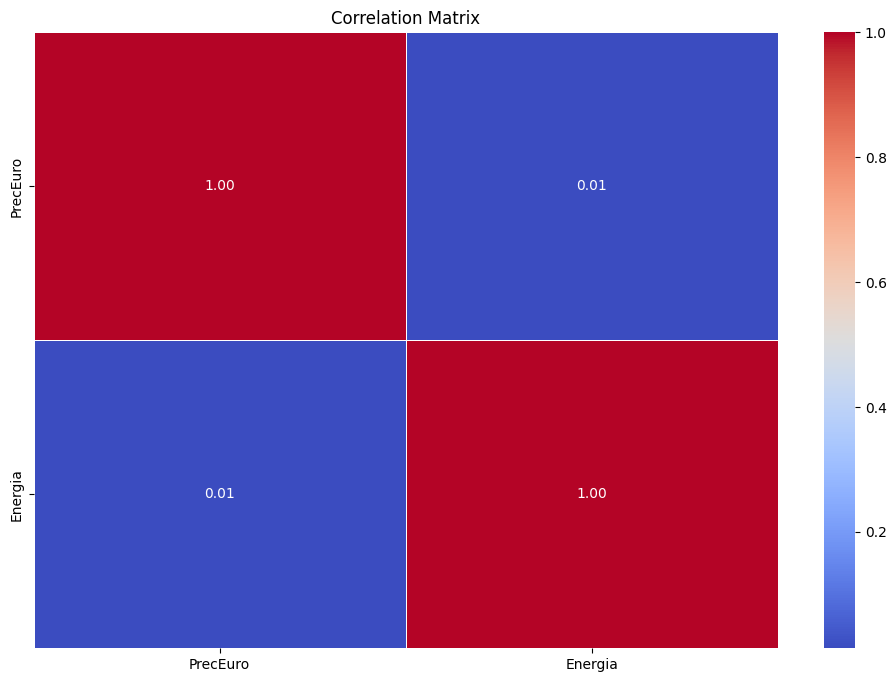

In [362]:
# 2. Correlation matrix 

numerical_cols = df_omie_labelled.select_dtypes(include=[np.number]).columns

corr_matrix = df_omie_labelled[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


## Feature Engineering

In [363]:
merged_df = df_omie_labelled.merge(df_unit_list, on='Codigo', how='left')
merged_df = merged_df.merge(df_filtered_cat, on='Codigo', how='left')
codes = df_filtered_cat['Codigo'].unique()
merged_df = merged_df[merged_df['Codigo'].isin(codes)]

In [364]:
len(merged_df)

703248

In [365]:
def time_features(df: pd.DataFrame):
    df['fechaHora'] = pd.to_datetime(df['fechaHora'])
    df['date'] = df['fechaHora'].dt.date
    df['hour'] = df['fechaHora'].dt.hour
    df['day_of_week'] = df['fechaHora'].dt.dayofweek  # Monday=0, Sunday=6
    df['month'] = df['fechaHora'].dt.month
    df['day_of_month'] = df['fechaHora'].dt.day
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df.sort_values(['fechaHora', 'Codigo'], inplace=True)
    df['t'] = (df['fechaHora'] - df['fechaHora'].min()).dt.total_seconds() / 3600
    
    def sin_cos_features(df: pd.DataFrame, period, K, time_col='t'):
        df = df.sort_values(['Codigo', 'fechaHora'])
        for k in range(1, K + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * df[time_col] / period)
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * df[time_col] / period)
        return df
    
    df = sin_cos_features(df, period=24, K=3)
    
    return df    

def cyclical_features(df: pd.DataFrame):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df
        
def interaction_features(df: pd.DataFrame):
    df['energia_hour_sin'] = df['lag_Energia'] * df['hour_sin']
    return df
    
def lags_features(df: pd.DataFrame):
    df.sort_values(['fechaHora'], inplace=True)
    df['lag_PrecEuro'] = df.groupby('Codigo')['PrecEuro'].shift(24*28)
    df['lag_Energia'] = df.groupby('Codigo')['Energia'].shift(24*28)
    df['lag_Energia'] = np.log(df['lag_Energia'] + 1)
    df['lag1_Energia'] = df.groupby('Codigo')['lag_Energia'].shift(1)
    df['lag24_Energia'] = df.groupby('Codigo')['lag_Energia'].shift(24)
    return df

In [366]:
def feature_engineering(data: pd.DataFrame):
    data['Energia_stationary'] = data['Energia'].diff()
    data = lags_features(data)
    data = time_features(data)
    data = cyclical_features(data)
    data = interaction_features(data)
    data = data.sort_values(['fechaHora', 'Codigo'])
    return data

In [367]:
merged_df = feature_engineering(merged_df)

In [368]:
def agg_features(df: pd.DataFrame):
    df['cum_energy'] = df.groupby(['Codigo', 'fechaHora'])['lag_Energia'].cumsum()
    return df

def rolling_mean_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    groups = ['Codigo', 'Categoria']
    times = [12, 24, 48, 168]
    for group in groups:
        for feature in features:
            for time in times:
                df[f'roll{time}_mean_{feature}'] = df.groupby(group)[feature] \
                    .transform(lambda x: x.rolling(window=time, min_periods=1).mean())
    return df

def ewm_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    groups = ['Codigo', 'Categoria']
    spans = [12, 24, 48, 168]
    for group in groups:
        for feature in features:
            for span in spans:
                df[f'ewm{span}_mean_{feature}'] = df.groupby(group)[feature] \
                    .transform(lambda x: x.ewm(span=span, min_periods=1).mean())
    return df

def diff_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    for feature in features:
        df[f'diff_{feature}'] = df.groupby('Codigo')[feature].diff()
        df[f'diff_{feature}'] = df.groupby(['Codigo'])[f'diff_{feature}'].transform(lambda x: x.fillna(x.mean()))
    return df

def volatility_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    groups = ['Codigo', 'Categoria']
    windows = [12, 24, 48, 168]
    for group in groups:
        for feature in features:
            for window in windows:
                df[f'volatility_{window}_{feature}'] = df.groupby(group)[feature] \
                    .transform(lambda x: x.rolling(window=window, min_periods=1).std())
                df[f'volatility_{window}_{feature}'] = df.groupby(['Codigo'])[f'volatility_{window}_{feature}'].transform(lambda x: x.fillna(x.mean()))

    return df

def fourrier_features(df: pd.DataFrame):    
    def apply_fft(group):
            X = fft.fft(group['lag_Energia'])
            N = len(X)
            group['lag_Energia_fft'] = np.abs(X) / N  # Normalize by length
            return group

    df = df.groupby('Codigo', group_keys=False).apply(apply_fft)
    return df

def frequency_power_features(df: pd.DataFrame):
    df['power_spectrum'] = df.groupby('Codigo')['lag_Energia'].transform(lambda x: np.abs(fft.fft(x))**2 / len(x))
    return df

In [369]:
def feature_transformation(x_train):
    # x_train = agg_features(x_train)
    x_train = rolling_mean_features(x_train)
    x_train = ewm_features(x_train)
    x_train = diff_features(x_train)
    x_train = volatility_features(x_train)
    x_train = fourrier_features(x_train)
    x_train = frequency_power_features(x_train)
    x_train['zero_indicator'] = (x_train['lag_Energia'] == 0).astype(int)
    return x_train

In [370]:
nan_counts = merged_df.isna().sum()
nan_counts = nan_counts[nan_counts > 1]
print(nan_counts)

Descripción             299782
Agente                  299782
Porcentaje_Propiedad    299782
Tipo_Unidad             299782
Zona/Frontera           299782
Tecnología              299782
lag_PrecEuro            209664
lag_Energia             209664
lag1_Energia            209976
lag24_Energia           217152
energia_hour_sin        209664
dtype: int64


## Modelling


In [371]:
# forecast period boundaries

forecast_start = pd.Timestamp('2024-06-01 23:00:00')
forecast_end   = pd.Timestamp('2024-06-29 23:00:00')


# Training data: all data before the forecast_start

train_df = merged_df[merged_df['fechaHora'] < forecast_start].copy()


In [372]:
# Define features: categorical, numerical, and metadata features

categorical_features = ['Codigo'] + [col for col in ['Categoria', 'Tipo_Unidad', 'Zona/Frontera', 'Tecnología', 'Agente'] if col in train_df.columns]

EXCLUDED_COLS = ['Energia', 'PrecEuro', 'Energia_stationary']
numerical_features = [col for col in merged_df.select_dtypes(include=[np.number]).columns if col not in EXCLUDED_COLS]

metadata_features = [col for col in ['agent_frequency', 'avg_propiedad_by_agent'] if col in train_df.columns]

# Final feature list and target definition

feature_cols = categorical_features + numerical_features + metadata_features
target_col = 'Energia_stationary'

# Convert categorical features to 'category' dtype

for col in categorical_features:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')

if not np.issubdtype(train_df['fechaHora'].dtype, np.datetime64):
    train_df['fechaHora'] = pd.to_datetime(train_df['fechaHora'])

train_df = train_df.dropna(subset=[target_col])


In [373]:
# --------------- Create Zero Indicator Feature ------------------

# A zero indicator feature is added to help the model differentiate between zero and non-zero regimes.

train_df['zero_indicator'] = (train_df['lag_Energia'] == 0).astype(int)
if 'zero_indicator' not in feature_cols:
    feature_cols.append('zero_indicator')

# Split data into features and target

X = train_df[feature_cols]
y = train_df[target_col]

print(f"Total training samples: {X.shape[0]}")


Total training samples: 703247


In [374]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 703247 entries, 1 to 712263
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Codigo                703247 non-null  category
 1   Categoria             703247 non-null  category
 2   Tipo_Unidad           403465 non-null  category
 3   Zona/Frontera         403465 non-null  category
 4   Tecnología            403465 non-null  category
 5   Agente                403465 non-null  category
 6   Porcentaje_Propiedad  403465 non-null  float64 
 7   lag_PrecEuro          493584 non-null  float64 
 8   lag_Energia           493584 non-null  float64 
 9   lag1_Energia          493272 non-null  float64 
 10  lag24_Energia         486096 non-null  float64 
 11  hour                  703247 non-null  int32   
 12  day_of_week           703247 non-null  int32   
 13  month                 703247 non-null  int32   
 14  day_of_month          703247 non-null  in

In [375]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# TimeSeriesSplit with 5 splits, a test set of 24*30 (720 hours, i.e. 30 days), and a gap of 24 hours
num_codigos = train_df['Codigo'].nunique()
tss = TimeSeriesSplit(n_splits=3, test_size=24 * 28 * num_codigos, gap=24)

epsilon = 0.001

def adjusted_mape(y_true, y_pred, epsilon=epsilon):
    """Adjusted MAPE: adds epsilon to denominator to avoid division by zero."""
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + epsilon))

# Best hyperparameters from Bayesian optimization (plus our regularization)

params_lgb = {
    # 'objective': 'tweedie',
    # 'tweedie_variance_power': 1.5,
    'metric': 'mae',
    'learning_rate': 0.04139126441377782,
    'num_leaves': 59,
    'max_depth': 7,
    'min_data_in_leaf': 26,
    'feature_fraction': 0.9999701887398744,
    'bagging_fraction': 0.6553188710984839,
    'bagging_freq': 6,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'seed': 42
}

mae_scores = []
mape_scores = []
fold = 1


####    Hyperparameter Tuning + LightGBM

+ Bayesian Optimization with Optuna to tune LightGBM’s hyperparameters using time-series cross-validation. 

+ Set up a search space for several key LightGBM hyperparameters (learning rate, num_leaves, max_depth, etc.).

+ We create an Optuna study in minimization mode and run 50 trials to find the best set of hyperparameters. After the study, we print out the best metrics and the corresponding hyperparameters.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

In [ ]:
class TimesFMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TimesFMModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
TIMESFM_MODEL_PARAMS = {
    'hidden_dim': 100,
    'output_dim': 1,
}

TIMESFM_TRAIN_PARAMS = {
    'lr': 0.01,
}


In [ ]:
def train_timesfm(
    X_train_tensor: torch.Tensor, 
    y_train_tensor: torch.Tensor,
    TIMESFM_MODEL_PARAMS: dict,
    TIMESFM_TRAIN_PARAMS: dict,
    epochs: int = 150
    ) -> TimesFMModel:

    timesfm_model = TimesFMModel(input_dim=X_train_tensor.shape[1], **TIMESFM_MODEL_PARAMS)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(timesfm_model.parameters(), **TIMESFM_TRAIN_PARAMS)
    
    # Train the model.
    timesfm_model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = timesfm_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
    return timesfm_model
    
def evaluate_timesfm(timesfm_model: TimesFMModel, X_test_tensor: torch.Tensor) -> np.ndarray:
    timesfm_model.eval()
    with torch.no_grad():
        y_pred_timesfm = timesfm_model(X_test_tensor).numpy().flatten()
        
    return y_pred_timesfm

In [ ]:
def prepare_timesfm(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame) -> tuple:
    if isinstance(X_train, pd.DataFrame):
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    elif isinstance(X_train, np.ndarray):
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    return X_train_tensor, y_train_tensor, X_test_tensor

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class OrdinalEncodingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Initialize the encoder with any desired options.
        self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.cat_cols = None

    def fit(self, X: pd.DataFrame, y=None):
        # Identify categorical columns (dtype object) in the training data.
        self.cat_cols = X.select_dtypes(include=['object']).columns
        # Fit the encoder on the categorical columns.
        self.encoder.fit(X[self.cat_cols])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transformed = X.copy()
        if self.cat_cols is not None:
            X_transformed[self.cat_cols] = self.encoder.transform(X_transformed[self.cat_cols])
        return X_transformed

In [ ]:
def custom_rolling_window_cv(data: pd.DataFrame, initial_train_window: int, forecast_horizon: int, step: int):
    """
    Custom rolling window cross-validation.
    """
    n = len(data)
    train_end = initial_train_window  
    while (train_end + forecast_horizon) <= n:
        train_idx = list(range(0, train_end))
        test_idx = list(range(train_end, train_end + forecast_horizon))
        yield train_idx, test_idx
        train_end += step
        
nunique_codes = X['Codigo'].nunique()
INITIAL_TRAIN_WINDOW = 24*28*nunique_codes
FORECAST_HORIZON = 24*28*nunique_codes
STEP = 24*7*nunique_codes

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 703247 entries, 1 to 712263
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Codigo                703247 non-null  category
 1   Categoria             703247 non-null  category
 2   Tipo_Unidad           403465 non-null  category
 3   Zona/Frontera         403465 non-null  category
 4   Tecnología            403465 non-null  category
 5   Agente                403465 non-null  category
 6   Porcentaje_Propiedad  403465 non-null  float64 
 7   lag_PrecEuro          493584 non-null  float64 
 8   lag_Energia           493584 non-null  float64 
 9   lag1_Energia          493272 non-null  float64 
 10  lag24_Energia         486096 non-null  float64 
 11  hour                  703247 non-null  int32   
 12  day_of_week           703247 non-null  int32   
 13  month                 703247 non-null  int32   
 14  day_of_month          703247 non-null  in

In [ ]:
# for train_index, val_index in tss.split(X):
    
for fold, (train_index, val_index) in enumerate(custom_rolling_window_cv(X, INITIAL_TRAIN_WINDOW, FORECAST_HORIZON, STEP)):

    X_tr = X.iloc[train_index]
    y_tr = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
    
    # X_tr = feature_transformation(X_tr)
    # X_val_fold = feature_transformation(X_val_fold)
    
    # ordinal_encoder = OrdinalEncodingTransformer()
    # X_tr = ordinal_encoder.fit_transform(X_tr)
    # X_val_fold = ordinal_encoder.transform(X_val_fold)
    
    # When constructing the LightGBM Dataset, we include both original categorical features and the zero_indicator
    
    lgb_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features + ['zero_indicator'])
    lgb_val = lgb.Dataset(X_val_fold, label=y_val_fold, categorical_feature=categorical_features + ['zero_indicator'])
    
    model = lgb.train(
        params_lgb,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    
    y_pred_fold = model.predict(X_val_fold, num_iteration=model.best_iteration)
    fold_mae = mean_absolute_error(y_val_fold, y_pred_fold)
    fold_mape = adjusted_mape(y_val_fold, y_pred_fold)
    print(f"Fold {fold}: MAE = {fold_mae:.4f}, MAPE = {fold_mape:.4f}")
    mae_scores.append(fold_mae)
    mape_scores.append(fold_mape)
    
    
            X_train_timesfm, y_train_timesfm, X_test_timesfm = prepare_timesfm(X_train, y_train, X_test)          
        timesfm_model = train_timesfm(X_train_timesfm, y_train_timesfm, TIMESFM_MODEL_PARAMS, TIMESFM_TRAIN_PARAMS)
        y_pred_timesfm = evaluate_timesfm(timesfm_model, X_test_timesfm)
        mae_timesfm = mae_score(y_test, y_pred_timesfm)
        mape_timesfm = mape_score(y_test, y_pred_timesfm)
        
        results['TimesFM']['mae'].append(mae_timesfm)
        results['TimesFM']['mape'].append(mape_timesfm)
        
        print(f"TimesFM   --> MAE: {mae_timesfm:.4f}, MAPE: {mape_timesfm:.4f}")
    
    
    
    # fold += 1


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's l1: 29.5328	valid_1's l1: 34.5524
Fold 0: MAE = 34.5524, MAPE = 683.6160
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[606]	training's l1: 12.5628	valid_1's l1: 31.191
Fold 1: MAE = 31.1910, MAPE = 1077.1581
Training until validation scores don't improve for 50 rounds


KeyboardInterrupt: 

In [ ]:
# The average MAE and average MAPE across all folds are computed

avg_mae = np.mean(mae_scores)
avg_mape = np.mean(mape_scores)

print("--------------------------------------------")
print(f"\nAverage MAE  across folds: {avg_mae:.4f}")
print("--------------------------------------------")
print(f"\nAverage MAPE across folds: {avg_mape:.4f}")


--------------------------------------------

Average MAE  across folds: 30.8604
--------------------------------------------

Average MAPE across folds: 1376.1515


### Error Metrics Insights 

+ In the Spanish electricity market challenge, where many energy offers are zero (or very low) and the target distribution is right-skewed, standard MAPE can be unstable. By adding a small constant (𝜖) to the denominator, you avoid division by zero and obtain a more stable error metric.

+ This MAPE gives you insight into how well your model forecasts relative errors, while MAE tells you the average absolute error. Together, they help assess model performance across plants with very different energy outputs.

In [ ]:
print("Training final model on all training data...")

final_lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features + ['zero_indicator'])

final_model = lgb.train(
    params_lgb,
    final_lgb_train,
    num_boost_round=200
)
print("Final model training complete.")

Training final model on all training data...


KeyboardInterrupt: 

In [ ]:
merged_df.columns

Index(['Codigo', 'Descripcion', 'fechaHora', 'PrecEuro', 'Energia', 'date',
       'hour', 'week', 'Descripción', 'Agente', 'Porcentaje_Propiedad',
       'Tipo_Unidad', 'Zona/Frontera', 'Tecnología', 'Categoria',
       'Energia_stationary', 'lag_PrecEuro', 'lag_Energia', 'lag1_Energia',
       'lag24_Energia', 'day_of_week', 'month', 'day_of_month', 'is_weekend',
       't', 'sin_24_1', 'cos_24_1', 'sin_24_2', 'cos_24_2', 'sin_24_3',
       'cos_24_3', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
       'energia_hour_sin'],
      dtype='object')

Feature importances saved to feature_importances.csv


/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_10434/4165561770.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='viridis')


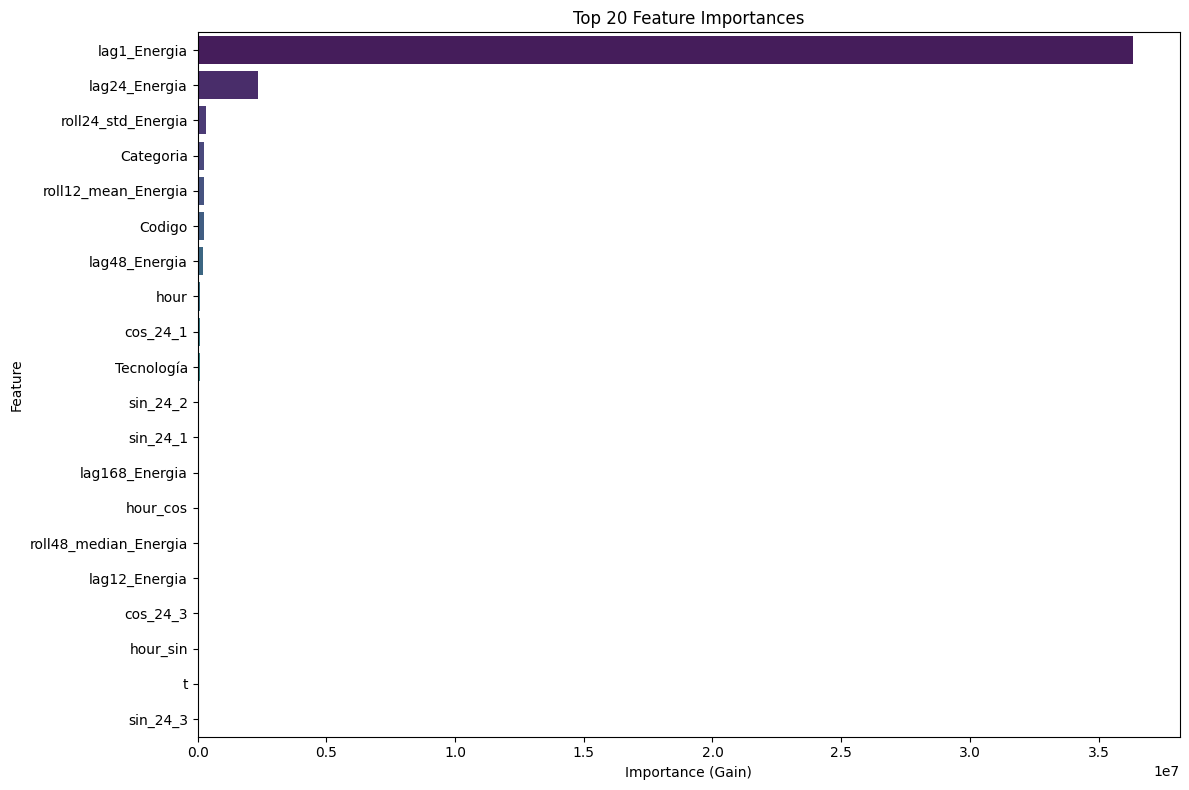

In [ ]:
feature_importances = final_model.feature_importance(importance_type='gain')
feature_names = final_model.feature_name()

# Create a DataFrame of feature importances
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Export the feature importances to a CSV file

feat_imp_df.to_csv("feature_importances.csv", index=False)
print("Feature importances saved to feature_importances.csv")

# Plot the top 20 most important features

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2. Plotting Pairwise Relationships with Target
# --------------------------------------------------

# For further insight, we can inspect how the most important features relate to the target variable "Energia".
# Here we take the top 5 features for clarity (you can adjust this number).
top_features = feat_imp_df.head(5)['feature'].tolist()

# Create a list of columns to plot (top features + the target column)
plot_columns = top_features + ['Energia']



How to Handle Lags in Forecasting

Historical Averages

+ compute the average values of your lag features (e.g., lag1, lag24, lag168, rolling statistics) from the training set, grouped by plant and hour.

+ For each plant and each forecasted hour, we can merge the historical average of each lag feature. This ensures that your forecast input mimics the training conditions without using future data.

+ Avoid Recursive Forecasting (if not implemented):
  If you don’t use a recursive forecasting approach (where you predict one step ahead and then use that prediction to compute the next lag), then filling lag features with historical averages is a safe and common practice.ç



Alternative Transformations:

+ If many offers are near zero, consider transformations like Box-Cox (with appropriate parameters) or modeling the ratio/difference directly.

Additional Lags and Aggregates:

+ Try incorporating more lag features (e.g., lag168 is good, but also consider lags for 12 or 48 hours) or aggregated features (rolling means/medians with different window sizes).

Hyperparameter Tuning and Regularization:

+ Use more extensive hyperparameter tuning (via Bayesian optimization or grid search) to find settings that reduce error.

+ Combine forecasts from LightGBM with those from linear models (like ElasticNet)




Date Range: 2024-02-29 00:00:00 2024-06-01 22:00:00


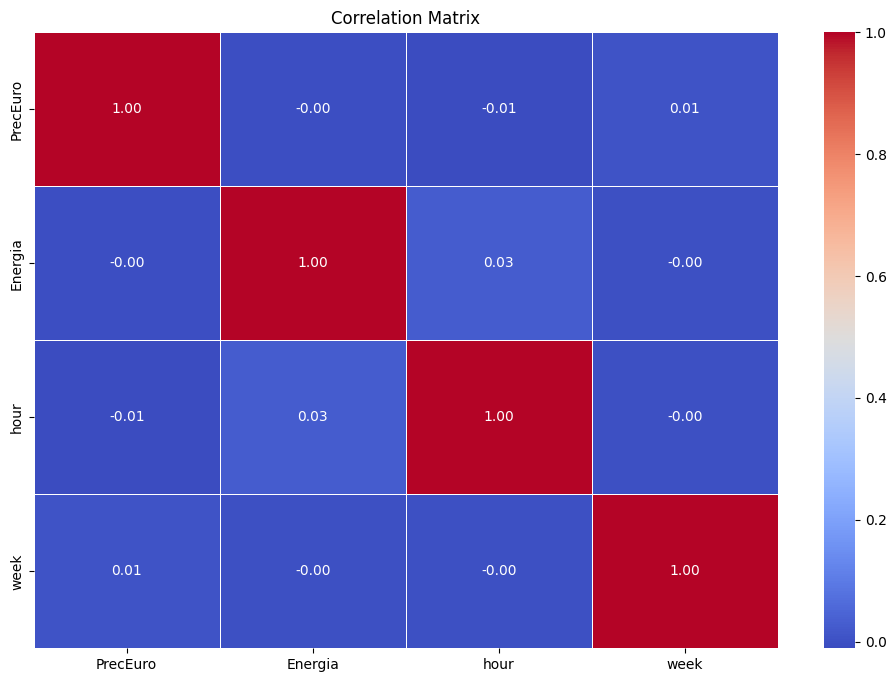

Merged DataFrame shape: (2409526, 45)


In [ ]:
# Convert fechaHora to datetime and extract initial time features

df_omie_labelled["fechaHora"] = pd.to_datetime(df_omie_labelled["fechaHora"])
print("\nDate Range:", df_omie_labelled["fechaHora"].min(), df_omie_labelled["fechaHora"].max())
df_omie_labelled["date"] = df_omie_labelled["fechaHora"].dt.date
df_omie_labelled["hour"] = df_omie_labelled["fechaHora"].dt.hour
df_omie_labelled["week"] = df_omie_labelled["fechaHora"].dt.isocalendar().week

numerical_cols = df_omie_labelled.select_dtypes(include=[np.number]).columns
corr_matrix = df_omie_labelled[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Improved Feature Engineering with Log Transformation, Additional Lags, and Rolling Aggregates

def prepare_merged_dataframe_improved(df_omie, df_cat, df_unit):
    """
    Merges datasets and creates features:
      - Standard time features and cyclical encodings.
      - Fourier series terms for daily (24h) and weekly (168h) seasonality.
      - Additional lag features:
            lag1 (1 hour), lag12 (12 hours), lag24 (24 hours), lag48 (48 hours), lag168 (168 hours).
      - Rolling aggregates:
            roll12_mean (12-hour rolling mean),
            roll48_median (48-hour rolling median),
            roll24_std (24-hour rolling standard deviation).
      - Target transformation: log_Energia = log(Energia + 1).
    """
    
    # Process primary dataset
    df_omie['fechaHora'] = pd.to_datetime(df_omie['fechaHora'])
    df_omie['date'] = df_omie['fechaHora'].dt.date
    df_omie['hour'] = df_omie['fechaHora'].dt.hour
    df_omie['day_of_week'] = df_omie['fechaHora'].dt.dayofweek  # Monday=0, Sunday=6
    df_omie['month'] = df_omie['fechaHora'].dt.month
    df_omie['day_of_month'] = df_omie['fechaHora'].dt.day
    df_omie['is_weekend'] = df_omie['day_of_week'].isin([5,6]).astype(int)
    
    # Cyclical encodings
    df_omie['hour_sin'] = np.sin(2 * np.pi * df_omie['hour'] / 24)
    df_omie['hour_cos'] = np.cos(2 * np.pi * df_omie['hour'] / 24)
    df_omie['dow_sin'] = np.sin(2 * np.pi * df_omie['day_of_week'] / 7)
    df_omie['dow_cos'] = np.cos(2 * np.pi * df_omie['day_of_week'] / 7)
    
    # Merge with supplemental datasets
    df = df_omie.merge(df_unit, on='Codigo', how='left')
    df = df.merge(df_cat, on='Codigo', how='left')
    df.sort_values(['Codigo', 'fechaHora'], inplace=True)
    
    # Create continuous time variable 't' (hours since start)
    df['t'] = (df['fechaHora'] - df['fechaHora'].min()).dt.total_seconds() / 3600

    # Add Fourier series terms for seasonality (daily and weekly, using 3 harmonics)
    for period in [24, 168]:
        for k in range(1, 4):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * df['t'] / period)
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * df['t'] / period)
    
    # Standard lags
    
    df['lag1_Energia'] = df.groupby('Codigo')['Energia'].shift(1)
    df['lag24_Energia'] = df.groupby('Codigo')['Energia'].shift(24)
    df['lag168_Energia'] = df.groupby('Codigo')['Energia'].shift(168)
    
    # Additional lags
    
    df['lag12_Energia'] = df.groupby('Codigo')['Energia'].shift(12)
    df['lag48_Energia'] = df.groupby('Codigo')['Energia'].shift(48)
    
    # Rolling Aggregates
    
    df['roll12_mean_Energia'] = df.groupby('Codigo')['Energia'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
    df['roll48_median_Energia'] = df.groupby('Codigo')['Energia'].transform(lambda x: x.rolling(window=48, min_periods=1).median())
    df['roll24_std_Energia'] = df.groupby('Codigo')['Energia'].transform(lambda x: x.rolling(window=24, min_periods=1).std())
    

    # Target Transformation
    
    df['log_Energia'] = np.log(df['Energia'] + 1)
    
    return df

# Apply feature engineering

merged_df = prepare_merged_dataframe_improved(df_omie_labelled, df_filtered_cat, df_unit_list)
print("Merged DataFrame shape:", merged_df.shape)


In [ ]:
# Splitting Training Data and Defining Features

forecast_start = pd.Timestamp('2024-06-01 23:00:00')
forecast_end   = pd.Timestamp('2024-06-29 23:00:00')
train_df = merged_df[merged_df['fechaHora'] < forecast_start].copy()

# Define feature lists (exclude original Energia; use log_Energia as target)

categorical_features = ['Codigo'] + [col for col in ['Categoria', 'Tipo_Unidad', 'Zona/Frontera', 'Tecnología', 'Agente'] if col in train_df.columns]
EXCLUDED_COLS = ['Energia', 'PrecEuro', 'log_Energia']
numerical_features = [col for col in merged_df.select_dtypes(include=[np.number]).columns if col not in EXCLUDED_COLS]
metadata_features = []  

feature_cols = categorical_features + numerical_features + metadata_features
target_col = 'log_Energia'

# Convert cat feat to cat type

for col in categorical_features:
    train_df[col] = train_df[col].astype('category')

train_df = train_df.dropna(subset=[target_col])

# Zero indicator 

train_df['zero_indicator'] = (train_df['lag1_Energia'] == 0).astype(int)
if 'zero_indicator' not in feature_cols:
    feature_cols.append('zero_indicator')

# Split training data into X and y

X = train_df[feature_cols]
y = train_df[target_col]
print(f"Total training samples: {X.shape[0]}")
print("Sample of lag features and aggregates:\n", X[['lag1_Energia','lag12_Energia','lag24_Energia','lag48_Energia','lag168_Energia',
                                                    'roll12_mean_Energia','roll48_median_Energia','roll24_std_Energia']].head())



Total training samples: 2409526
Sample of lag features and aggregates:
       lag1_Energia  lag12_Energia  lag24_Energia  lag48_Energia  \
0              NaN            NaN            NaN            NaN   
1069           0.0            NaN            NaN            NaN   
2138           0.0            NaN            NaN            NaN   
3207           0.0            NaN            NaN            NaN   
4276           0.0            NaN            NaN            NaN   

      lag168_Energia  roll12_mean_Energia  roll48_median_Energia  \
0                NaN                  0.0                    0.0   
1069             NaN                  0.0                    0.0   
2138             NaN                  0.0                    0.0   
3207             NaN                  0.0                    0.0   
4276             NaN                  0.0                    0.0   

      roll24_std_Energia  
0                    NaN  
1069                 0.0  
2138                 0.0  
3207    

In [ ]:
# TimeSeries Cross-Validation Setup

tss = TimeSeriesSplit(n_splits=3, test_size=24*28*train_df['Codigo'].nunique(), gap=24)
epsilon = 0.001
def adjusted_mape(y_true, y_pred, epsilon=epsilon):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + epsilon))

# Model Training with LightGBM

params_lgb = {
    'metric': 'mae',
    'learning_rate': 0.04139,
    'num_leaves': 59,
    'max_depth': 7,
    'min_data_in_leaf': 26,
    'feature_fraction': 0.99997,
    'bagging_fraction': 0.65532,
    'bagging_freq': 6,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'seed': 42
}

mae_scores, mape_scores = [], []
fold = 1
for train_index, val_index in tss.split(X):
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features + ['zero_indicator'])
    lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features + ['zero_indicator'])
    
    model = lgb.train(params_lgb, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_val],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
    y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
    mae_scores.append(mean_absolute_error(y_val, y_pred_val))
    mape_scores.append(adjusted_mape(y_val, y_pred_val))
    print(f"Fold {fold}: MAE = {mae_scores[-1]:.4f}, MAPE = {mape_scores[-1]:.4f}")
    fold += 1

print("Average MAE across folds:", np.mean(mae_scores))
print("Average MAPE across folds:", np.mean(mape_scores))

# Train final LightGBM model on all training data

final_lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features + ['zero_indicator'])
final_model = lgb.train(params_lgb, final_lgb_train, num_boost_round=200)
print("Final LightGBM model training complete.")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	training's l1: 0.0723555	valid_1's l1: 0.146071
Fold 1: MAE = 0.1461, MAPE = 14.2685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	training's l1: 0.0731949	valid_1's l1: 0.088586
Fold 2: MAE = 0.0886, MAPE = 12.8060
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	training's l1: 0.0674027	valid_1's l1: 0.0498762
Fold 3: MAE = 0.0499, MAPE = 4.2820
Average MAE across folds: 0.09484434563240153
Average MAPE across folds: 10.452168994776278
Final LightGBM model training complete.


In [ ]:
# Forecasting Setup: Handling Lags Using Historical Averages 

# Create forecast DataFrame for the period June 1, 2024, 23:00 to June 29, 2024, 23:00

all_plants = merged_df['Codigo'].unique()
forecast_times = pd.date_range(start=forecast_start, end=forecast_end, freq='H')
forecast_df = pd.DataFrame([(codigo, ts) for codigo in all_plants for ts in forecast_times],
                           columns=['Codigo', 'fechaHora'])

# Compute basic time features for forecast period

forecast_df['fechaHora'] = pd.to_datetime(forecast_df['fechaHora'])
forecast_df['hour'] = forecast_df['fechaHora'].dt.hour
forecast_df['day_of_week'] = forecast_df['fechaHora'].dt.dayofweek
forecast_df['month'] = forecast_df['fechaHora'].dt.month
forecast_df['day_of_month'] = forecast_df['fechaHora'].dt.day
forecast_df['week'] = forecast_df['fechaHora'].dt.isocalendar().week
forecast_df['is_weekend'] = forecast_df['day_of_week'].isin([5,6]).astype(int)

# Cyclical encodings for forecast period

forecast_df['hour_sin'] = np.sin(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['hour_cos'] = np.cos(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['dow_sin']  = np.sin(2 * np.pi * forecast_df['day_of_week'] / 7)
forecast_df['dow_cos']  = np.cos(2 * np.pi * forecast_df['day_of_week'] / 7)

# Create continuous time variable 't'

min_time = merged_df['fechaHora'].min()
forecast_df['t'] = (forecast_df['fechaHora'] - min_time).dt.total_seconds() / 3600

# Add Fourier series terms for forecast data (24h and 168h, using 3 harmonics)

for period in [24, 168]:
    for k in range(1, 4):
        forecast_df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * forecast_df['t'] / period)
        forecast_df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * forecast_df['t'] / period)

# Compute Historical Averages for Lag Features from Training Data

avg_features = train_df.groupby(['Codigo', 'hour']).agg({
    'lag1_Energia': 'mean',
    'lag12_Energia': 'mean',
    'lag24_Energia': 'mean',
    'lag48_Energia': 'mean',
    'lag168_Energia': 'mean',
    'roll12_mean_Energia': 'mean',
    'roll48_median_Energia': 'mean',
    'roll24_std_Energia': 'mean',
    'PrecEuro': 'mean'
}).reset_index().rename(columns={
    'lag1_Energia': 'lag1_Energia_avg',
    'lag12_Energia': 'lag12_Energia_avg',
    'lag24_Energia': 'lag24_Energia_avg',
    'lag48_Energia': 'lag48_Energia_avg',
    'lag168_Energia': 'lag168_Energia_avg',
    'roll12_mean_Energia': 'roll12_mean_Energia_avg',
    'roll48_median_Energia': 'roll48_median_Energia_avg',
    'roll24_std_Energia': 'roll24_std_Energia_avg',
    'PrecEuro': 'PrecEuro_avg'
})
forecast_df = forecast_df.merge(avg_features, on=['Codigo', 'hour'], how='left')

# lag and rolling features are replaced with the forecast with the historical averages

forecast_df['lag1_Energia'] = forecast_df['lag1_Energia_avg']
forecast_df['lag12_Energia'] = forecast_df['lag12_Energia_avg']
forecast_df['lag24_Energia'] = forecast_df['lag24_Energia_avg']
forecast_df['lag48_Energia'] = forecast_df['lag48_Energia_avg']
forecast_df['lag168_Energia'] = forecast_df['lag168_Energia_avg']
forecast_df['roll12_mean_Energia'] = forecast_df['roll12_mean_Energia_avg']
forecast_df['roll48_median_Energia'] = forecast_df['roll48_median_Energia_avg']
forecast_df['roll24_std_Energia'] = forecast_df['roll24_std_Energia_avg']
forecast_df['PrecEuro'] = forecast_df['PrecEuro_avg']
forecast_df.drop(columns=['lag1_Energia_avg','lag12_Energia_avg','lag24_Energia_avg','lag48_Energia_avg',
                            'lag168_Energia_avg','roll12_mean_Energia_avg','roll48_median_Energia_avg',
                            'roll24_std_Energia_avg','PrecEuro_avg'], inplace=True)

# Merge static plant information 

static_info = merged_df.drop_duplicates(subset='Codigo')[['Codigo', 'Categoria', 'Tipo_Unidad', 'Zona/Frontera', 'Tecnología', 'Agente']]
forecast_df = forecast_df.merge(static_info, on='Codigo', how='left')

# Add zero indicator

forecast_df['zero_indicator'] = 0


/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_10434/2087976900.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_times = pd.date_range(start=forecast_start, end=forecast_end, freq='H')
/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_10434/2087976900.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_features = train_df.groupby(['Codigo', 'hour']).agg({


In [ ]:
# Ensure forecast feature columns match training feature columns
feature_cols = [col for col in feature_cols if col in forecast_df.columns]
X_forecast = forecast_df[feature_cols].copy()
missing_features = [col for col in X.columns if col not in X_forecast.columns]
if missing_features:
    print("Adding missing features to X_forecast:", missing_features)
    for col in missing_features:
        X_forecast[col] = 0
X_forecast = X_forecast[X.columns]
for col in categorical_features:
    if col in X_forecast.columns:
        X_forecast[col] = X_forecast[col].astype('category')

Adding missing features to X_forecast: ['Porcentaje_Propiedad']


In [ ]:
print("Generating forecasts with LightGBM...")
forecast_df['log_Energia_pred_lgb'] = final_model.predict(X_forecast)


Generating forecasts with LightGBM...


In [ ]:
# Inverse the log transformation: Energia = exp(pred) - 1
forecast_df['Energia'] = np.exp(forecast_df['log_Energia_pred_lgb']) - 1

In [ ]:
output_df = forecast_df[['Codigo', 'fechaHora', 'Energia']].copy()
output_csv_path = 'Challenge1_404TeamNotFound.csv'
output_df.to_csv(output_csv_path, index=False)
print(f"Forecasts saved to {output_csv_path}")

Forecasts saved to Challenge1_404TeamNotFound.csv


Feature importances saved to feature_importances.csv


/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_10434/704630359.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='viridis')


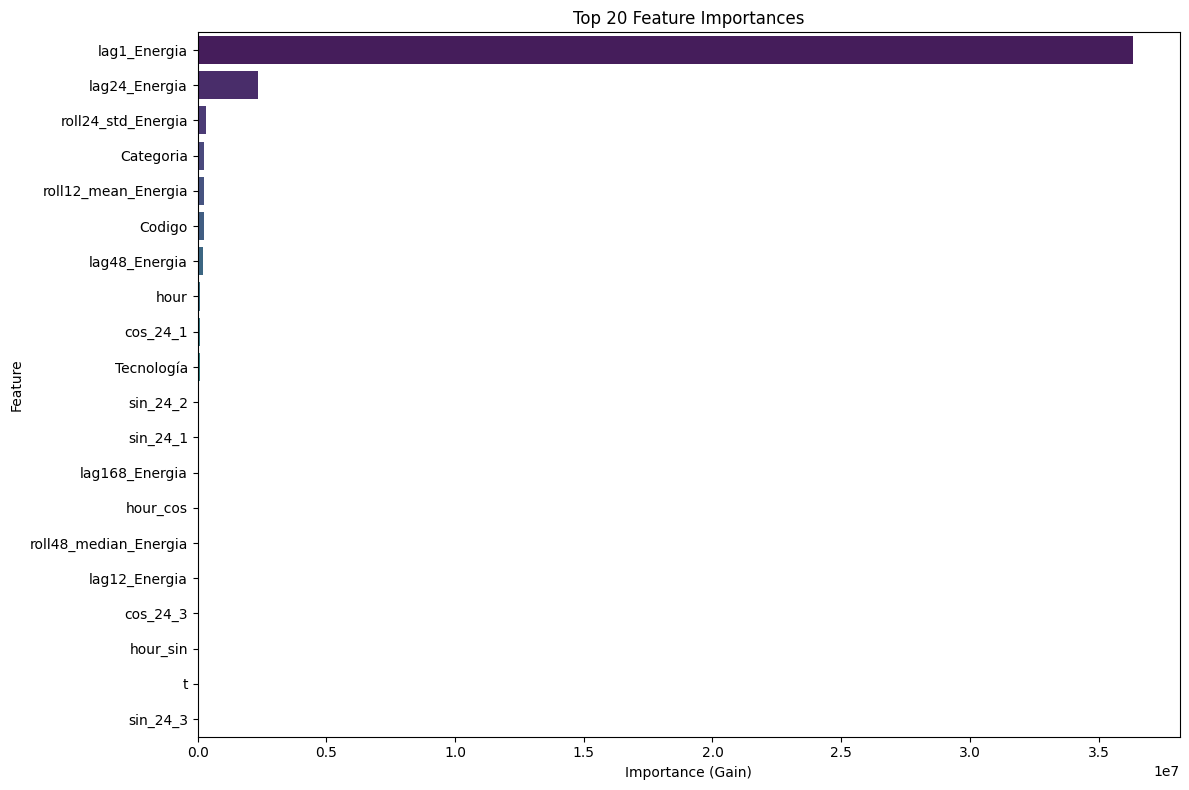

In [ ]:

# Feature Importance and Visualization

feature_importances = final_model.feature_importance(importance_type='gain')
feature_names = final_model.feature_name()
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
feat_imp_df.to_csv("feature_importances.csv", index=False)
print("Feature importances saved to feature_importances.csv")

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
